## Outline and Introduction

- Examining the structure
- Opening an ASDF file
- Summarizing the structure of the file
- Accessing the contents
- Searching for content

### Basic organization of ASDF files

Understanding the basic organizational structures of an ASDF file will help in navigating the contents of such files. In brief, the organization consists of an arbitrary nesting of the equivalent of Python lists and dictionaries. As a result, getting to any particular item involves either indexing by number when a list is encountered (YAML parlance is an "array") or by a key when a dictionary is encountered (YAML parlance is "map"). Furthermore, if any item is preceded by a YAML "tag", Python generally knows (if the appropriate software is installed) how to turn it into a corresponding Python object. The most common instance of this case is for ndarray or table data. If a tag for a ndarray is encountered, Python will turn this into a numpy array automatically (though perhaps not until you wish to access the array). But many other kinds of tags and corresponding Python objects will be encountered.

### Reading a JWST ASDF file

Unbeknownst to many, while the JWST pipeline normally works with FITS files, it has been designed to work with ASDF files as well (though there is currently a small change needed to enable this). Turning JWST data products into ASDF files is easy, and our first example will be with such a file. First some preliminaries such as doing the needed imports and references to the data files used for this tutorial (they must be downloaded, but this notebook handles that).

In [1]:
import asdf
from astropy.utils.data import download_file
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 10)
from matplotlib import pyplot as plt
file1_url_1 = 'https://data.science.stsci.edu/redirect/ASDF/asdf_tut_1.asdf'



In [2]:
# This is a large file and may take a while to download
filepath = download_file(file1_url_1)
# Wait until download completes (when 'In [*]' changes the  '* to a number')
# Ignore warnings

In [3]:
# This may generate a couple warnings
af = asdf.open(filepath)

c:\users\perry\documents\github\asdf\asdf\asdf.py:212: AsdfWarning: File 'file:///C:/Users/perry/AppData/Local/Temp/astropy-download-22568-crpabj9a' was created with extension 'asdf.extension.BuiltinExtension' from package asdf-2.7.1, but older version asdf-2.6.1.dev59+gde25fec is installed
  warnings.warn(fmt_msg, AsdfWarning)
c:\users\perry\documents\github\asdf\asdf\asdf.py:193: AsdfWarning: File 'file:///C:/Users/perry/AppData/Local/Temp/astropy-download-22568-crpabj9a' was created with extension 'jwst.transforms.jwextension.JWSTExtension', which is not currently installed (from package jwst-0.17.1)
  warnings.warn(fmt_msg, AsdfWarning)


### Quick look at contents

In [4]:
af.info()

root.tree (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): Space Telescope Science Institute
│ ├─homepage (str): http://github.com/spacetelescope/asdf
│ ├─name (str): asdf
│ └─version (str): 2.7.1
├─history (dict)
│ └─extensions (list) ...
├─_fits_hash (str): 54bba15f8a9f8c34e751761fefb701f513d2cef137ed722e3f014055c9f439fc
├─area (NDArrayType): shape=(2048, 2048), dtype=float32
├─data (NDArrayType): shape=(2048, 2048), dtype=float32
├─dq (NDArrayType): shape=(2048, 2048), dtype=uint32
├─err (NDArrayType): shape=(2048, 2048), dtype=float32
├─meta (dict)
│ ├─asn (dict) ...
│ ├─bunit_data (str): MJy/sr
│ ├─bunit_err (str): MJy/sr
│ ├─cal_step (dict) ...
│ ├─calibration_software_revision (str): RELEASE
│ └─22 not shown
├─var_flat (NDArrayType): shape=(2048, 2048), dtype=float32
├─var_poisson (NDArrayType): shape=(2048, 2048), dtype=float32
└─var_rnoise (NDArrayType): shape=(2048, 2048), dtype=float32
Some nodes not shown.


The info() method is extremely useful for examining the contents of an ASDF file. There is a command line version as well discussed later. But first we'll do a little data access. Note all the items labeled as NDArrayTypes. As you might guess, these are all images so we will access the main science image, which has te name "data". First thing to know is that when you open ASDF files, images are not loaded into memory when it is opened, but information about that image (or array) is. When you actually access the data itself, it will be loaded. We will do that now

### Look at the science data

In [5]:
sci = af.tree['data']
sci.shape

(2048, 2048)

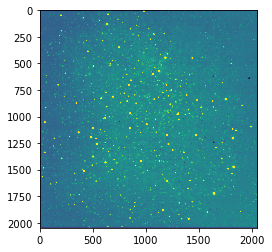

In [6]:
# Now display the image
plt.imshow(sci, vmin=0, vmax=3)

This data set is a simulated image of 47 Tuc. Given that JWST has not been launched yet, most of the current data files are not very interesting to view. Let's examine the contents of the file a bit more using the optional arguments for the info() method. This [link](https://asdf.readthedocs.io/en/2.7.1/api/asdf.info.html#asdf.info) shows all the options, but we will show a few examples.

In [7]:
# to show all items
af.info(max_rows=None)

root.tree (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): Space Telescope Science Institute
│ ├─homepage (str): http://github.com/spacetelescope/asdf
│ ├─name (str): asdf
│ └─version (str): 2.7.1
├─history (dict)
│ └─extensions (list)
│   ├─[0] (ExtensionMetadata)
│   ├─[1] (ExtensionMetadata)
│   ├─[2] (ExtensionMetadata)
│   ├─[3] (ExtensionMetadata)
│   └─[4] (ExtensionMetadata)
├─_fits_hash (str): 54bba15f8a9f8c34e751761fefb701f513d2cef137ed722e3f014055c9f439fc
├─area (NDArrayType): shape=(2048, 2048), dtype=float32
├─data (NDArrayType): shape=(2048, 2048), dtype=float32
├─dq (NDArrayType): shape=(2048, 2048), dtype=uint32
├─err (NDArrayType): shape=(2048, 2048), dtype=float32
├─meta (dict)
│ ├─asn (dict)
│ │ ├─pool_name (str): singleton
│ │ └─table_name (str): singleton
│ ├─bunit_data (str): MJy/sr
│ ├─bunit_err (str): MJy/sr
│ ├─cal_step (dict)
│ │ ├─assign_wcs (str): COMPLETE
│ │ ├─dark_sub (str): COMPLETE
│ │ ├─dq_init (str): COMPLETE
│ │ ├─flat_field (str): COMPLETE
│

In [8]:
# To disable the printing of values
af.info(show_values=False)

root.tree (AsdfObject)
├─asdf_library (Software)
│ ├─author (str)
│ ├─homepage (str)
│ ├─name (str)
│ └─version (str)
├─history (dict)
│ └─extensions (list) ...
├─_fits_hash (str)
├─area (NDArrayType): shape=(2048, 2048), dtype=float32
├─data (NDArrayType): shape=(2048, 2048), dtype=float32
├─dq (NDArrayType): shape=(2048, 2048), dtype=uint32
├─err (NDArrayType): shape=(2048, 2048), dtype=float32
├─meta (dict)
│ ├─asn (dict) ...
│ ├─bunit_data (str)
│ ├─bunit_err (str)
│ ├─cal_step (dict) ...
│ ├─calibration_software_revision (str)
│ └─22 not shown
├─var_flat (NDArrayType): shape=(2048, 2048), dtype=float32
├─var_poisson (NDArrayType): shape=(2048, 2048), dtype=float32
└─var_rnoise (NDArrayType): shape=(2048, 2048), dtype=float32
Some nodes not shown.


### Accessing metadata

Most metadata for JWST files is under the toplevel attribute meta. There is a lot of information there, and some if it is more complicated than a simple value. Some examples:

In [9]:
meta = af.tree['meta']
meta

{'asn': {'pool_name': 'singleton', 'table_name': 'singleton'},
 'bunit_data': 'MJy/sr',
 'bunit_err': 'MJy/sr',
 'cal_step': {'assign_wcs': 'COMPLETE',
  'dark_sub': 'COMPLETE',
  'dq_init': 'COMPLETE',
  'flat_field': 'COMPLETE',
  'gain_scale': 'SKIPPED',
  'group_scale': 'SKIPPED',
  'jump': 'COMPLETE',
  'linearity': 'COMPLETE',
  'photom': 'COMPLETE',
  'ramp_fit': 'COMPLETE',
  'refpix': 'COMPLETE',
  'saturation': 'COMPLETE',
  'superbias': 'COMPLETE'},
 'calibration_software_revision': 'RELEASE',
 'calibration_software_version': '0.17.1',
 'coordinates': {'reference_frame': 'ICRS'},
 'date': '2020-09-30T14:29:41.341',
 'dither': {'pattern_size': 'NONE',
  'position_number': 1,
  'primary_type': 'NONE',
  'subpixel_number': 1,
  'subpixel_total_points': 1,
  'subpixel_type': 'UNKNOWN',
  'total_points': 1},
 'exposure': {'datamode': 33,
  'duration': 128.84112,
  'end_time': 57877.0048426241,
  'exposure_time': 107.3676,
  'frame_time': 10.73676,
  'group_time': 10.73676,
  'gro

In [10]:
# Simple value:
meta['filename']

'xxx.asdf'

In [11]:
# Collection of values as a dict
meta['exposure']

{'datamode': 33,
 'duration': 128.84112,
 'end_time': 57877.0048426241,
 'exposure_time': 107.3676,
 'frame_time': 10.73676,
 'group_time': 10.73676,
 'groupgap': 0,
 'integration_time': 107.3676,
 'mid_time': 57877.00422128382,
 'nframes': 1,
 'ngroups': 10,
 'nints': 1,
 'nresets_at_start': 2,
 'nresets_between_ints': 1,
 'readpatt': 'RAPID',
 'sample_time': 10,
 'start_time': 57877.00359994354,
 'type': 'NRC_IMAGE'}

In [12]:
meta['exposure']['integration_time']

107.3676

### What about comments?

The short answer is that there are not any in the file. We will be working on tools to extract the equivalent information from the associated schemas that define what attributes and values are expected in a JWST file, but there isn't one yet. Generally speaking one can look at the corresponding schema to find out definitions and units for values, but that won't be covered in this tutorial. For Roman we expect to use quantities for many values, which have explicit units. But JWST had to mirror the values in FITS keyword/value cards so quantities are not generally used.

### About ASDF Terminology 

The structure of an ASDF file is essentially a tree. Each node may take on one of three general characteristics:

1. It may be a simple value, e.g., a string, number, or boolean value.
2. It may be a list of values, in which case each of these values is indexed by number
3. It may be a dictionary of values, in which case each of these values is indexed by the dictionary key.
4. (did he say 3?) A reference to a value elsewhere in the file, either a simple value, list, or dict

So branching at nodes is either done by lists or dictionaries. Simple values are endpoints of a branch. When tags are used, a whole subtree may be turned into a corresponding Python object, which in Python is the endpoint of a branch. To illustrate, in the YAML header, an array is characterized by a number of item that defined the array and where the data are located. But when reading this YAML header into Python, all that information is used to create a numpy array and information about that array is now embedded in the numpy array itself (e.g., its shape, type and other attributes). A "path" to a node is essentially the sequence of indices needed to locate it. In the case above, the science data is only one level down, and its path is ['data']. In the original YAML header, there would be deeper levels, but they have all been used to create the numpy array. Much of the metadata for this data set is in the attribute labeled 'meta'

### Searching for Content

In [13]:
# To show only where array data is located
af.search(type='NDArrayType')

root.tree (AsdfObject)
├─area (NDArrayType): shape=(2048, 2048), dtype=float32
├─data (NDArrayType): shape=(2048, 2048), dtype=float32
├─dq (NDArrayType): shape=(2048, 2048), dtype=uint32
├─err (NDArrayType): shape=(2048, 2048), dtype=float32
├─var_flat (NDArrayType): shape=(2048, 2048), dtype=float32
├─var_poisson (NDArrayType): shape=(2048, 2048), dtype=float32
└─var_rnoise (NDArrayType): shape=(2048, 2048), dtype=float32

In [14]:
# Find any WCS-related items
sr = af.search('wcs')

In [15]:
sr

root.tree (AsdfObject)
└─meta (dict)
  ├─cal_step (dict)
  │ └─assign_wcs (str): COMPLETE
  ├─ref_file (dict)
  │ └─specwcs (dict)
  ├─wcs (WCS)
  └─wcsinfo (dict)
    └─wcsaxes (int): 2

In [16]:
sr.paths

["root.tree['meta']['wcs']",
 "root.tree['meta']['wcsinfo']",
 "root.tree['meta']['cal_step']['assign_wcs']",
 "root.tree['meta']['ref_file']['specwcs']",
 "root.tree['meta']['wcsinfo']['wcsaxes']"]

In [17]:
print(af.tree['meta']['wcs'])

  From     Transform  
-------- -------------
detector CompoundModel
    v2v3      v23tosky
   world          None


### Using the WCS

This is one of those tags that tells the Python ASDF library to convert this node and all below it into a GWCS object. By using this, you can convert pixel coordinates into sky coordinates.

For example, if you wish to see where pixel 100, 200 is on the sky, or the converse, what pixel a sky coordinate lands in:

In [18]:
wcs = af.tree['meta']['wcs']
wcs(100,200) # both ra and dec are in degrees

[array(5.92172828), array(-72.0099005)]

In [19]:
wcs.invert(5.9, -72) # return pixel coordinates corresponding to this RA, Dec

(474.07667369756473, 765.8849791013195)

In [20]:
# what is the output coordinate frame and units?
wcs.output_frame

<CelestialFrame(name="world", unit=(Unit("deg"), Unit("deg")), axes_names=('lon', 'lat'), axes_order=(0, 1), reference_frame=<ICRS Frame>)>

### Command line tools

There is a command line tool that provides a number of utilities for use with ASDF files. Most relevant for this tutorial are the info. For example, you can get information on an ASDF file by typing at the shell level:
```
asdftool info <filename>
```

This variant of the asdftool command accepts the following options corresponding to the optional keyword options for the info method:
```
--max-rows MAX_ROWS  maximum number of lines
--max-cols MAX_COLS  maximum length of line
--show-values
--no-show-values
```

For example:

```
asdftool info --max-rows 100 myfile.asdf
```

More advanced use of asdftool will be discussed in other tutorials. The documentation for it can be obtained by typing `asdftool --help` 